In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import easyocr
import pandas as pd
import mediapipe as mp

## 1. Local Grayscale (0-255)

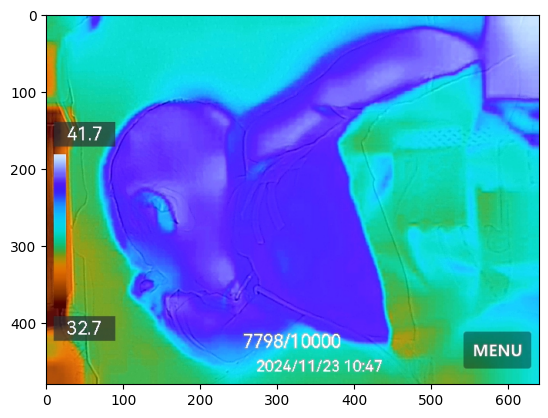

In [2]:
img_path = "images/46/23.11.24/HM20241123104704.jpeg" #Foto de la escala original
img = cv2.imread(img_path)
img.dtype
plt.imshow(img)

In [3]:
img.dtype

dtype('uint8')

Lo primero es ubicar las coordenadas de la barra dentro de la imagen térmica del neonato

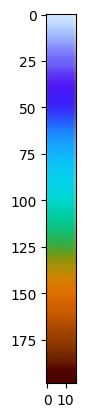

In [4]:
bar = img[182:381,10:26]
plt.imshow(bar)

In [5]:
bar.shape

(199, 16, 3)

Una vez conocemos la posición tanto para las fotos horizontales como para las verticales, hacemos una función para extraerla

In [6]:
def get_bar(img):
    if img.shape == (480,640,3):
        bar = img[182:381,16]
    else:
        bar = img[181:446,16]
    return bar

In [7]:
def opt2(image):
    '''
    Transforms the image into an apropiate gray scale considering the thermal gradient shown on the lateral bar.T

    Parameters
    ----------
    image : np.array
        The image to transform. We assume is taken by a thermal camera with resolution 480*640 with rgb values.

    Returns
    --------
    index_matrix : np.array
        Grayscale converted image using the lateral thermal bar as reference.
    '''
    bar = get_bar(image)
    np_img = np.array(image).reshape(image.shape[0]*image.shape[1],3).astype(float)
    distances = np.linalg.norm(np_img[:,np.newaxis,:]-bar[np.newaxis,:,:],axis=2)
    
    indices = np.ones(np_img.shape[:-1])*255 - np.argmin(distances,axis=1)*255/bar.shape[0]
    index_matrix = indices.reshape(image.shape[0],image.shape[1])

    return index_matrix

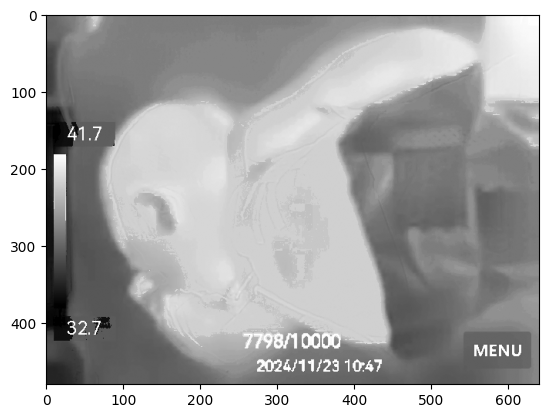

In [8]:
gimg = opt2(img)
plt.imshow(gimg,"gray")

In [9]:
cv2.imwrite("./temporary/GrayScale2.png",gimg)

[ WARN:0@10.019] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


True

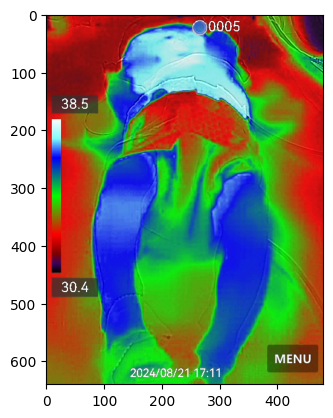

In [10]:
img_vert = "images/29/21.08.24-22.08.24/HM20240821171107.jpeg"
img2 = cv2.imread(img_vert)
plt.imshow(img2)

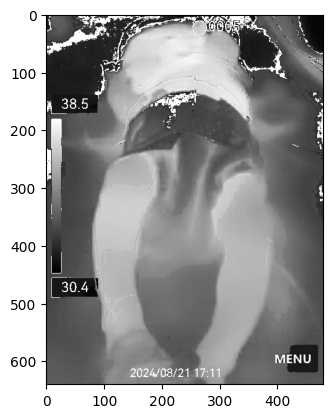

In [11]:
gimg2 = opt2(img2)
plt.imshow(gimg2,"gray")

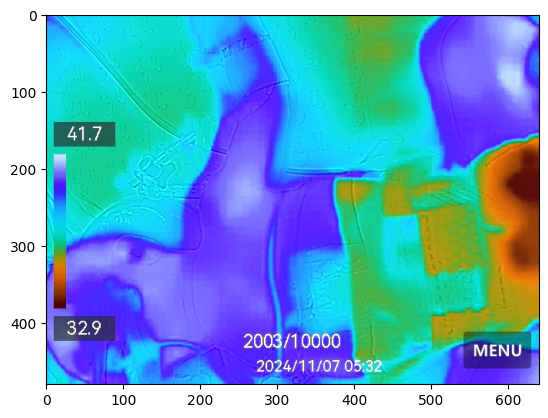

In [12]:
img_alt = "images/42/07.11.24/HM20241107053230.jpeg"
img3 = cv2.imread(img_alt)
plt.imshow(img3)

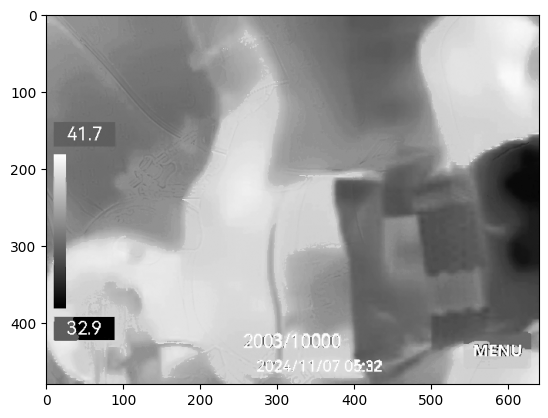

In [13]:
gimg3 = opt2(img3)
plt.imshow(gimg3,"gray")

In [14]:
cv2.imwrite("./temporary/GrayScale1.png",gimg3)

True

## 2. Creating a global temp scale

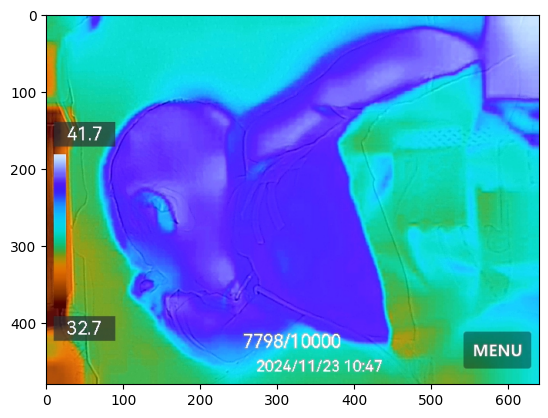

In [15]:
plt.imshow(img)

In [16]:
low_cote, high_cote = 15,45
model = easyocr.Reader(['es'])

In [17]:
# He tenido que usar la versión 11.0.0 de pillow porque no funciona sino
def limit_finder(image,reader):
    """
    This function extracts the information shown of the boxes of the photo. The top one shows the maximum temperature and the bottom one the minimum.

    Parameters
    ----------
    image : np.array
        The image to transform. We assume is taken by a thermal camera with resolution 480*640 with rgb values.

    reader : easyocr.Reader
        Model previouslly trained to detect and recognize text.

    Returns:
    ---------
    top : float
        Highest temperature in the image. Corresponds to the index 0 of the thermal gradient.

    bot : float
        Lowest temperature in the image. Corresponds to the index -1 of the thermal gradient.
    """
    if image.shape == (480,640,3):
        box_1 = image[141:168,25:75]
        box_2 = image[393:420,25:75]
    else:
        box_1 = image[141:168,25:75]
        box_2 = image[458:485,25:75]

    top = float(reader.readtext(box_1,allowlist='0123456789.',detail=0)[0])
    bot = float(reader.readtext(box_2,allowlist='0123456789.',detail=0)[0])
    return top,bot

def temp_classifier(image,reader):
    """
    Extracts the temperature for each pixel of the image and converts it locally to grayscale.

    Parameters
    ----------
    image : np.array
        The image to transform. We assume is taken by a thermal camera with resolution 480*640 with rgb values.
    
    reader : easyocr.Reader
        Model previouslly trained to detect and recognize text.

    Returns
    --------
    index_matrix : np.array
        Grayscale converted image using the lateral thermal bar as reference.
    
    temps : np.array
        Matrix containing the temperature of each pixel based on the temperature benchmark shown on the image.
    """
    bar = get_bar(image)
    np_img = np.array(image).reshape(image.shape[0]*image.shape[1],3).astype(float)
    distances = np.linalg.norm(np_img[:,np.newaxis,:]-bar[np.newaxis,:,:],axis=2)
    
    indices = np.ones(np_img.shape[:-1])*255 - np.argmin(distances,axis=1)*255/bar.shape[0]
    index_matrix = indices.reshape(image.shape[0],image.shape[1])

    # Extraer temperatura
    TOP, BOT = limit_finder(image,reader)
    temps = index_matrix*(TOP-BOT)/255 + BOT
    return index_matrix, temps

In [18]:
limit_finder(img2,model)

(38.5, 30.4)

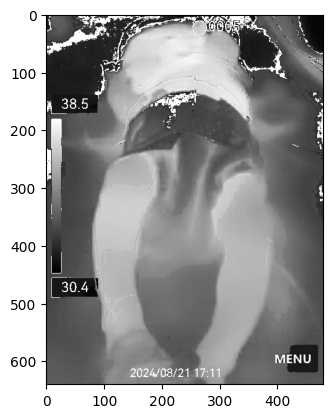

In [19]:
img_grayscale, temp2 = temp_classifier(img2,model)
plt.imshow(img_grayscale,"gray")

In [20]:
temp2

array([[30.91962264, 30.95018868, 30.98075472, ..., 30.52226415,
        30.67509434, 35.56566038],
       [30.91962264, 30.95018868, 30.98075472, ..., 30.52226415,
        30.61396226, 35.56566038],
       [30.95018868, 30.98075472, 30.98075472, ..., 30.52226415,
        30.55283019, 30.91962264],
       ...,
       [33.36490566, 33.36490566, 33.36490566, ..., 33.08981132,
        33.05924528, 33.05924528],
       [33.36490566, 33.36490566, 33.36490566, ..., 33.05924528,
        33.05924528, 33.05924528],
       [33.36490566, 33.36490566, 33.36490566, ..., 33.05924528,
        33.05924528, 33.05924528]])

## 3. Batching

Teniendo la función de extraccióón de temperatura podemos hacer una serie de cosas como tratar de detectar al neonato. Sin embargo una de las cosas más importantes es mejorar aún más los tiempos. Para ello realizaré batching para poder aplicar eso a más de una foto a la vez empleando *cupy*

In [21]:
import cupy as cp
import gc

In [22]:
def temp_classifier_gpu(image,reader):
    """
    Extracts the temperature for each pixel of the image and converts it locally to grayscale.

    Parameters
    ----------
    image : np.array
        The image to transform. We assume is taken by a thermal camera with resolution 480*640 with rgb values.
    
    reader : easyocr.Reader
        Model previouslly trained to detect and recognize text.

    Returns
    --------
    index_matrix : np.array
        Grayscale converted image using the lateral thermal bar as reference.
    
    temps : np.array
        Matrix containing the temperature of each pixel based on the temperature benchmark shown on the image.
    """
    bar = cp.asarray(get_bar(image))
    cp_img = cp.asarray(image).reshape(image.shape[0]*image.shape[1],3).astype(float)
    distances = cp.linalg.norm(cp_img[:,cp.newaxis,:]-bar[cp.newaxis,:,:],axis=2)
    
    indices = cp.ones(cp_img.shape[:-1])*255 - cp.argmin(distances,axis=1)*255/bar.shape[0]
    index_matrix = indices.reshape(image.shape[0],image.shape[1])

    # Extraer temperatura
    TOP, BOT = limit_finder(image,reader)
    if TOP>=100: TOP=TOP/10
    if BOT>=100: BOT=BOT/10
    temps = index_matrix*(TOP-BOT)/255 + BOT

    del cp_img, distances, indices, bar #Lo he añadido a ver si se arregla lo de la memoria

    # Filtro de imagenes no útiles
    #if np.count_nonzero(temps>36) < image.shape[0]*image.shape[1]*0.35:
    #    temps = None
    #    index_matrix = None
    #    print("No es un bebé")

    return index_matrix.get(), temps.get()

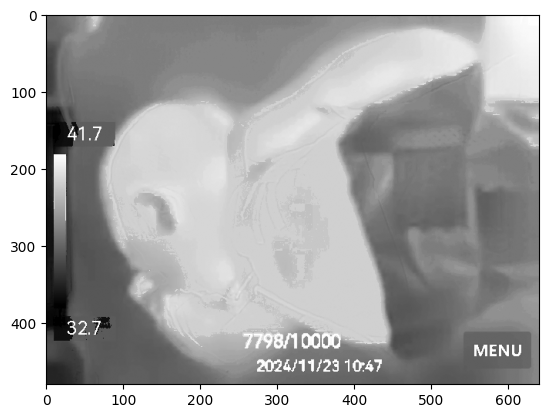

In [23]:
img_grayscale, temp = temp_classifier_gpu(img,model)
plt.imshow(img_grayscale,"gray")

In [24]:
temp

array([[36.72512563, 36.6798995 , 36.63467337, ..., 41.65477387,
        41.65477387, 41.65477387],
       [36.6798995 , 36.6798995 , 36.58944724, ..., 41.65477387,
        41.65477387, 41.65477387],
       [36.6798995 , 36.63467337, 36.58944724, ..., 41.65477387,
        41.65477387, 41.65477387],
       ...,
       [34.14723618, 34.14723618, 34.14723618, ..., 37.49396985,
        37.49396985, 37.49396985],
       [34.14723618, 34.14723618, 34.19246231, ..., 37.49396985,
        37.49396985, 37.49396985],
       [34.14723618, 34.14723618, 34.19246231, ..., 37.49396985,
        37.49396985, 37.49396985]])

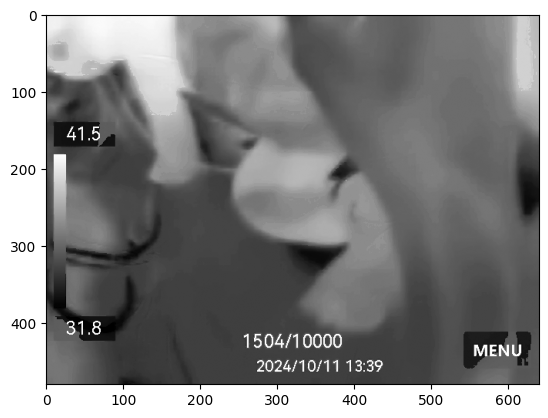

In [25]:
#testing filter
weird_img = cv2.imread("./images/39/11.10.24/HM20241011133952.jpeg")
img_grayscale, temp = temp_classifier_gpu(weird_img,model)
plt.imshow(img_grayscale,"gray")

## 4. Creating the Dataset

In [26]:
import pandas as pd
from glob import glob

In [27]:
columns = ["ImagePath","LocalGrayscale","Temperature"]

df = pd.DataFrame(columns=columns)

In [28]:
jpeg_files = []

for i in range(29,56):
    origin_folder = f"images/{i}/*"

    subfolders = glob(origin_folder)
    for sub in subfolders:
        image_paths = glob(f"{sub}/*.jpeg")
        filtered = [f for f in image_paths if not (f.endswith('.VIS.jpeg') or f.endswith('_VIS.jpeg'))]
        jpeg_files.append(filtered)


In [29]:
len(jpeg_files[1])

500

In [30]:
#csv_start = 0
#csv_end = 0
#csv_index = csv_start
def batch(csv_start, csv_end):
    
#for fold in jpeg_files[csv_start:csv_end+1]:
    columns = ["ImagePath","LocalGrayscale","Temperature"]

    df = pd.DataFrame(columns=columns)
    for i, p in enumerate(fold):
        img = cv2.imread(p)
        gc.collect()

        height, width, _ = img.shape
        #print(f"Image {p} has resolution: {height} x {width}")
        
        gray,t = temp_classifier_gpu(img,model)
        df.loc[i] = [p,gray,t.get()]

        del gray,t
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()
        
        cp.cuda.Device(0).synchronize()
        gc.collect()
    
    df.to_csv(f"./temporary/extracted_data{csv_index}.csv",index=False)
    csv_index += 1

## 2.1 Finding the baby

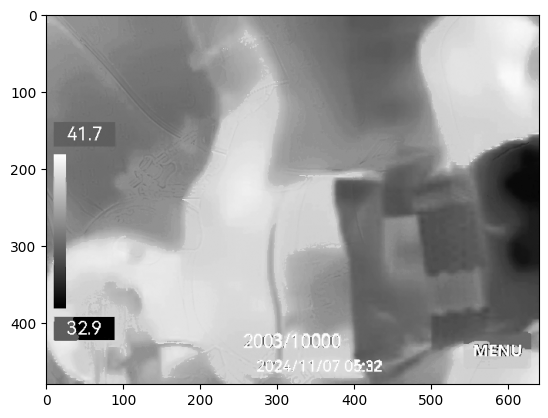

In [31]:
gimg, temp = temp_classifier_gpu(img3,model)
plt.imshow(gimg,"gray")

In [32]:
simple_gimg = gimg.astype(np.uint8)

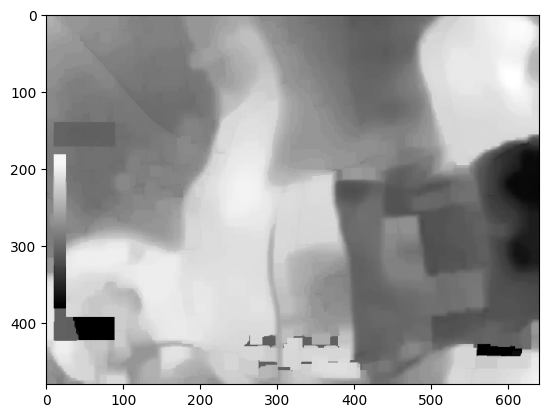

In [33]:
kernel = np.ones((5,5), np.uint8)

gimg_erosion = cv2.erode(simple_gimg, kernel, iterations=3)
gimg_opening = cv2.dilate(gimg_erosion, kernel, iterations=3)

plt.imshow(gimg_opening,"gray")

In [34]:
from skimage.filters import threshold_li,try_all_threshold,threshold_minimum

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


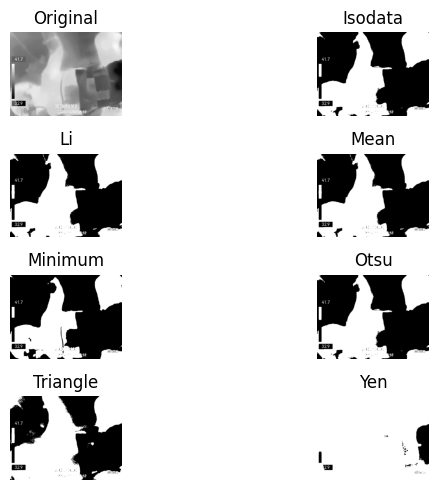

In [35]:
fig, ax = try_all_threshold(temp)
plt.show()

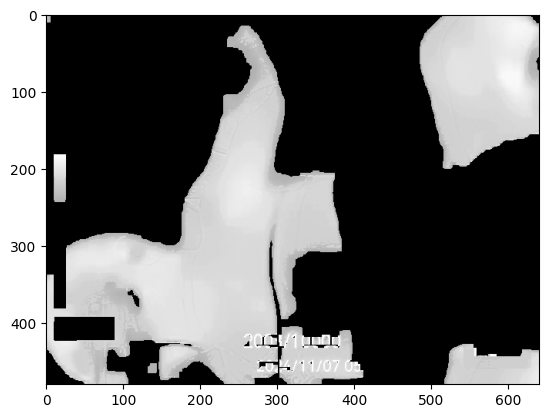

In [36]:
def get_mask(temp):
    kernel = np.ones((5,5), np.uint8)

    t = threshold_minimum(temp) #Check threshold
    #t= 38
    mask = temp > t

    num_mask = np.where(mask,255,0).astype(np.uint8)

    num_mask = cv2.erode(num_mask, kernel, iterations=2)
    num_mask = cv2.dilate(num_mask, kernel, iterations=2)
    num_mask = cv2.erode(num_mask, kernel, iterations=2)
    num_mask = cv2.dilate(num_mask, kernel, iterations=2)

    #Adjustments for bar and boxes
    '''
    if img.shape == (480,640,3):
        mask[182:381,10:26] = True
        mask[141:168,25:75] = True
        mask[393:420,25:75] = True
    else:
        mask[141:168,25:75] = True
        mask[458:485,25:75] = True
        mask[181:446,10:26] = True
    '''
    return num_mask==255

m = get_mask(temp)

masked_image = np.where(m,gimg,0)

plt.imshow(masked_image,"gray")

In [37]:
from skimage.morphology import skeletonize
from skimage.measure import label
from skimage.color import label2rgb

labeled_array, num_features = label(m,background=0,return_num=True)

counts = np.bincount(labeled_array.ravel())[1:]  # Empieza en 0 (fondo)
largest_label = np.argmax(counts) + 1 # Cojo el más repetido

cluster_indices = np.argwhere(labeled_array == largest_label)

# Centro del cluster
centroid = cluster_indices.mean(axis=0)

# Cuestióón de tipos (int para el index)
centroid_index_y, centroid_index_x = np.round(centroid).astype(int)

print("Centro:", centroid_index_x, centroid_index_y)

Centro: 209 311


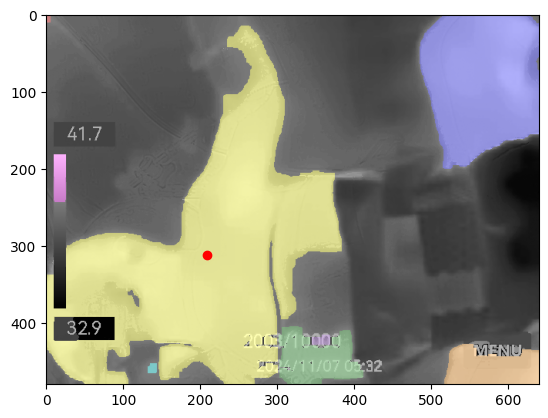

In [38]:
image_label_overlay = label2rgb(labeled_array, image=simple_gimg, bg_label=0)
ax = image_label_overlay
plt.scatter(centroid_index_x,centroid_index_y,color="red")
plt.imshow(image_label_overlay)

(311, 224, 40.071859296482415)

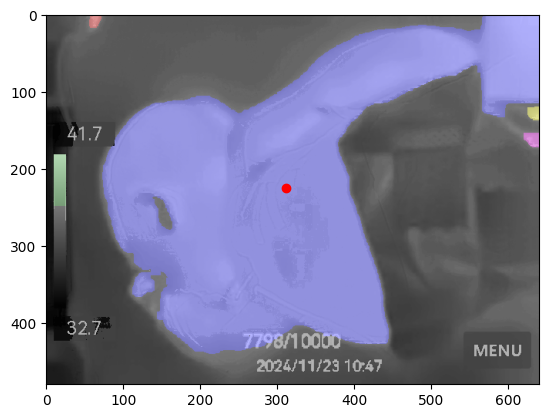

In [39]:
def chest_finder(im, model,plot=True):
    gimg, temp = temp_classifier_gpu(im,model)
    m = get_mask(temp)
    simple_gimg = gimg.astype(np.uint8)

    labeled_array, num_features = label(m,background=0,return_num=True)

    counts = np.bincount(labeled_array.ravel())[1:]  # Empieza en 0 (fondo)
    largest_label = np.argmax(counts) + 1 # Cojo el más repetido

    cluster_indices = np.argwhere(labeled_array == largest_label)

    # Centro del cluster
    centroid = cluster_indices.mean(axis=0)

    # Cuestióón de tipos (int para el index)
    centroid_index_y, centroid_index_x = np.round(centroid).astype(int)

    if plot:
        image_label_overlay = label2rgb(labeled_array, image=simple_gimg, bg_label=0)
        ax = image_label_overlay
        plt.scatter(centroid_index_x,centroid_index_y,color="red")
        plt.imshow(image_label_overlay)

    temp_core = temp[centroid_index_y][centroid_index_x]

    return centroid_index_x, centroid_index_y, temp_core

x,y,t = chest_finder(img,model)
x,y,t 


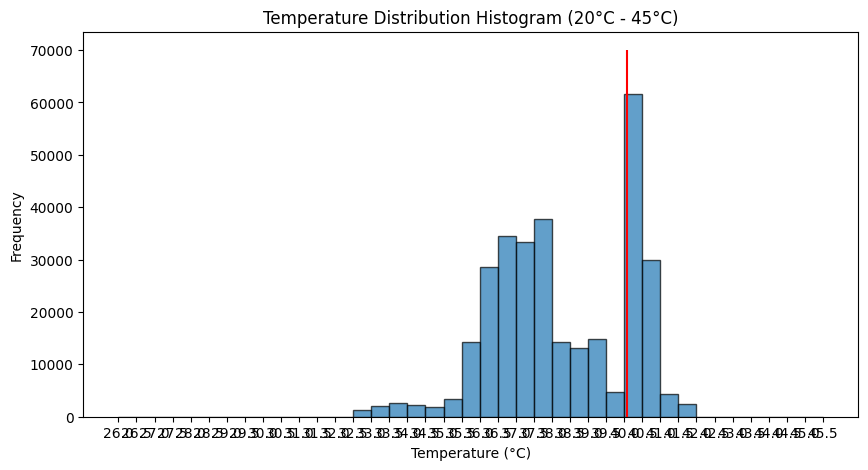

In [40]:
temperatures = temp.flatten()

bins = np.arange(26, 46, 0.5)

plt.figure(figsize=(10, 5))
plt.hist(temperatures, bins=bins, edgecolor="black", alpha=0.7)


plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Temperature Distribution Histogram (20°C - 45°C)")
plt.xticks(bins)
plt.vlines(t,0,70000,colors="red")
plt.show()

### Como de fiable es la deteccion del pecho?

In [41]:
df = pd.read_csv("test_set.csv",sep=";")
df

File_Path       Chest  \
0             images/41/02.11.24/HM20241102095756.jpeg  (567, 103)   
1         images/40/25.10.24 (2)/HM20241025140659.jpeg  (199, 384)   
2               images/33/8.9.24/HM20240908082906.jpeg  (171, 161)   
3             images/49/28.11.24/HM20241128102807.jpeg  (353, 168)   
4    images/50/02.12.24-03.12.24/HM20241203044034.jpeg  (323, 121)   
..                                                 ...         ...   
196           images/46/21.11.24/HM20241121091816.jpeg  (333, 282)   
197      images/33/8.9.24-9.9.24/HM20240908172817.jpeg   (96, 153)   
198       images/49/29.11.24 (2)/HM20241129172003.jpeg         NaN   
199           images/36/01.10.24/HM20241001025538.jpeg  (146, 214)   
200  images/44/18.11.24-19.11.24/HM20241120034031.jpeg  (368, 128)   

           Arm1        Arm2        Leg1        Leg2  
0           NaN         NaN  (396, 253)         NaN  
1    (248, 200)         NaN         NaN         NaN  
2     (196, 64)   (82, 275)  (528, 100)  (253, 393)  
3     (381, 10)  (356, 370)         NaN         NaN  
4           NaN  (250, 330)         NaN         NaN  
..          ...         ...         ...         ...  
196  (201, 161)         NaN         NaN  (486, 362)  
197   (173, 46)   (38, 240)  (458, 152)         NaN  
198         NaN         NaN         NaN         NaN  
199   (111, 47)  (168, 338)  (526, 224)         NaN  
200         NaN  (406, 352)         NaN         NaN  

[201 rows x 6 columns]

In [42]:
import ast

df["Chest"][41]


nan

In [43]:
accumulated_x_error = 0
accumulated_y_error = 0
value_count = 0

for pos in range(1,75):
    path = df["File_Path"][pos]
    img = cv2.imread(path)

    #plt.imshow(img)
    if not pd.isna(df["Chest"][pos]):
        x,y,t = chest_finder(cv2.imread(path),model,plot=False)
        test_coord_x, test_coord_y = ast.literal_eval(df["Chest"][pos])
        if img.shape == (640,480):
            aux = test_coord_x
            test_coord_x = 480-test_coord_y
            test_coord_y = aux

        x_error = (test_coord_x-x)
        y_error = (test_coord_y-y)
        accumulated_y_error += abs(y_error)
        accumulated_x_error += abs(x_error)
        value_count += 1
        print("IMG",pos,": Teníamos anotado",df["Chest"][pos],". Nosotros hemos obtenido:",(x,y),"Error de x=",x_error,"Error de y=",y_error)

aver_x_error = accumulated_x_error/value_count
aver_y_error = accumulated_y_error/value_count

aver_x_error,aver_y_error

IMG 1 : Teníamos anotado (199, 384) . Nosotros hemos obtenido: (164, 417) Error de x= 35 Error de y= -33
IMG 2 : Teníamos anotado (171, 161) . Nosotros hemos obtenido: (166, 202) Error de x= 5 Error de y= -41
IMG 3 : Teníamos anotado (353, 168) . Nosotros hemos obtenido: (332, 210) Error de x= 21 Error de y= -42
IMG 4 : Teníamos anotado (323, 121) . Nosotros hemos obtenido: (314, 150) Error de x= 9 Error de y= -29
IMG 5 : Teníamos anotado (107, 350) . Nosotros hemos obtenido: (242, 331) Error de x= -135 Error de y= 19
IMG 6 : Teníamos anotado (297, 232) . Nosotros hemos obtenido: (283, 245) Error de x= 14 Error de y= -13
IMG 7 : Teníamos anotado (192, 144) . Nosotros hemos obtenido: (235, 203) Error de x= -43 Error de y= -59
IMG 8 : Teníamos anotado (112, 322) . Nosotros hemos obtenido: (317, 202) Error de x= -205 Error de y= 120
IMG 9 : Teníamos anotado (215, 270) . Nosotros hemos obtenido: (255, 330) Error de x= -40 Error de y= -60
IMG 10 : Teníamos anotado (299, 316) . Nosotros hemo

(56.0, 44.559322033898304)

In [44]:
pos=87
path = df["File_Path"][pos]
img = cv2.imread(path)
gimg, temp = temp_classifier_gpu(img,model)
temp

array([[36.53969849, 36.4919598 , 36.44422111, ..., 37.54221106,
        37.54221106, 37.54221106],
       [36.53969849, 36.4919598 , 36.44422111, ..., 37.54221106,
        37.54221106, 37.54221106],
       [36.53969849, 36.53969849, 36.44422111, ..., 37.54221106,
        37.54221106, 37.54221106],
       ...,
       [34.86884422, 34.86884422, 34.86884422, ..., 37.30351759,
        37.54221106, 37.54221106],
       [34.86884422, 34.86884422, 34.86884422, ..., 37.30351759,
        37.30351759, 37.30351759],
       [34.86884422, 34.86884422, 34.86884422, ..., 37.30351759,
        37.30351759, 37.54221106]])

In [45]:
x,y,t = chest_finder(cv2.imread(path),model,plot=False)

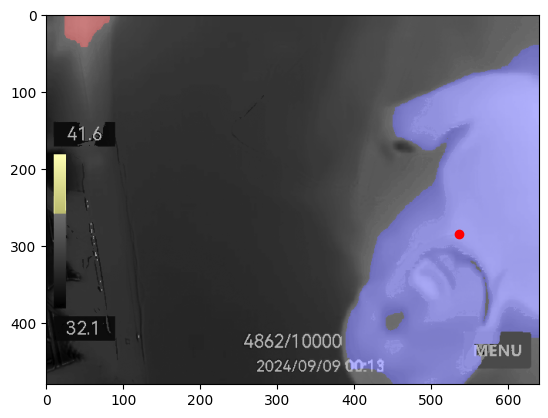

In [46]:
im = cv2.imread(df["File_Path"][87])
gimg, temp = temp_classifier_gpu(im,model)
m = get_mask(temp)
simple_gimg = gimg.astype(np.uint8)

labeled_array, num_features = label(m,background=0,return_num=True)

counts = np.bincount(labeled_array.ravel())[1:]  # Empieza en 0 (fondo)
largest_label = np.argmax(counts) + 1 # Cojo el más repetido
cluster_indices = np.argwhere(labeled_array == largest_label)

# Centro del cluster
centroid = cluster_indices.mean(axis=0)
# Cuestióón de tipos (int para el index)
centroid_index_y, centroid_index_x = np.round(centroid).astype(int)

image_label_overlay = label2rgb(labeled_array, image=simple_gimg, bg_label=0)
ax = image_label_overlay
plt.scatter(centroid_index_x,centroid_index_y,color="red")
plt.imshow(image_label_overlay)

temp_core = temp[centroid_index_y][centroid_index_x]

## Experimento con las fotos originales

In [47]:
img_limb_detection2 = cv2.imread("images/47/01.12.24 (1)/HM20241201174656.VIS.jpeg")
img_limb_detection = cv2.imread("images/40/23.10.24/HM20241023144414.VIS.jpeg")

img_mp = cv2.cvtColor(img_limb_detection, cv2.COLOR_BGR2RGB)


libEGL warning: DRI3: Screen seems not DRI3 capable
libEGL warning: DRI2: failed to authenticate
I0000 00:00:1741793205.291012  185699 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741793205.300937  185789 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: llvmpipe (LLVM 15.0.7, 256 bits)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741793205.441133  185768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741793205.517070  185764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741793205.552734  185766 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


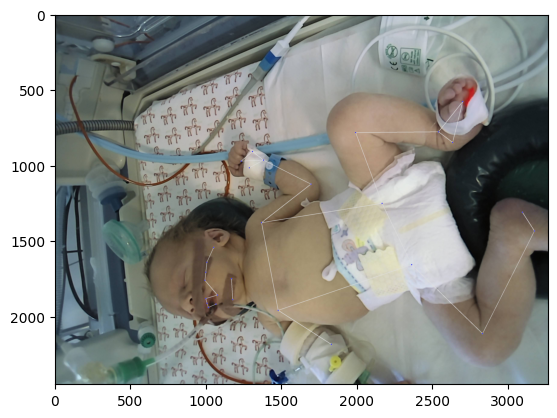

In [48]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

results = pose.process(img_mp)

if results.pose_landmarks:
    mp_drawing.draw_landmarks(img_mp, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

plt.imshow(img_mp)

In [49]:
if results.pose_landmarks:

    height,width,_ = img_mp.shape
    # Get landmark coordinates
    landmarks = results.pose_landmarks.landmark
    
    # Extract specific key points
    key_points = {
        "head": {
            "nose": np.array((landmarks[mp_pose.PoseLandmark.NOSE].x*width, landmarks[mp_pose.PoseLandmark.NOSE].y*height)),
            "left_eye": np.array((landmarks[mp_pose.PoseLandmark.LEFT_EYE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_EYE].y*height)),
            "right_eye": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_EYE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_EYE].y*height)),
            "left_ear": np.array((landmarks[mp_pose.PoseLandmark.LEFT_EAR].x*width, landmarks[mp_pose.PoseLandmark.LEFT_EAR].y*height)),
            "right_ear": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_EAR].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_EAR].y*height)),
        },
        "hands": {
            "left_wrist": np.array((landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x*width, landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y*height)),
            "right_wrist": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y*height)),
            "left_elbow": np.array((landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x*width, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y*height)),
            "right_elbow": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y*height))
        },
        "legs": {
            "left_knee": np.array((landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y*height)),
            "right_knee": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y*height)),
            "left_ankle": np.array((landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y*height)),
            "right_ankle": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y*height)),
        },
        "core" : {
            "left_shoulder": np.array((landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x*width, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y*height)),
            "right_shoulder": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y*height)),
            "left_hip": np.array((landmarks[mp_pose.PoseLandmark.LEFT_HIP].x*width,landmarks[mp_pose.PoseLandmark.LEFT_HIP].y*height)),
            "right_hip": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y*height))
        }    
    }

    # Print key points
    for part, points in key_points.items():
        print(f"{part.upper()}:")
        for point_name, coords in points.items():
            print(f"  {point_name}: {coords}")
else:
    print("No pose detected")

HEAD:
  nose: [1075.37366867 1859.24380875]
  left_eye: [ 998.27834702 1708.72986031]
  right_eye: [1006.2537117  1913.14522362]
  left_ear: [1050.93318558 1544.13728428]
  right_ear: [1065.36915207 1919.41010857]
HANDS:
  left_wrist: [1380.93398666  966.12343884]
  right_wrist: [2064.01052856 2535.02843857]
  left_elbow: [1694.60488129 1125.47317171]
  right_elbow: [1829.55184937 2185.65429497]
LEGS:
  left_knee: [1990.56923676  784.07932949]
  right_knee: [2830.52665329 2114.05665207]
  left_ankle: [2539.61183167  779.91317225]
  right_ankle: [3174.42977142 1435.69127369]
CORE:
  left_shoulder: [1367.66920853 1380.21838474]
  right_shoulder: [1477.69583702 1960.15403938]
  left_hip: [2165.35372925 1252.70267487]
  right_hip: [2361.36746979 1658.71875572]


In [50]:
predicted_core = (key_points["core"]["left_shoulder"]+
                  key_points["core"]["right_shoulder"]+
                  key_points["core"]["left_hip"]+
                  key_points["core"]["right_hip"]+
                  key_points["head"]["nose"]+
                  key_points["head"]["left_eye"]+
                  key_points["head"]["right_eye"])/7
predicted_core

array([1493.14171028, 1676.13039248])

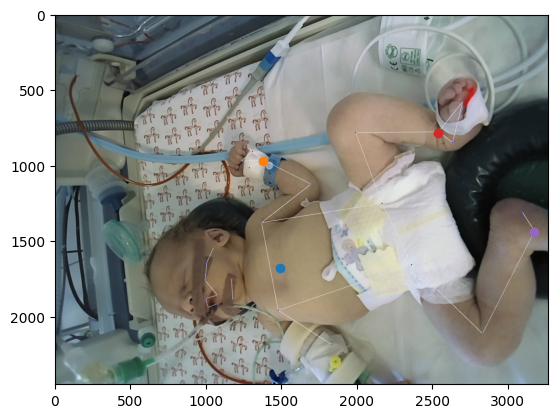

In [51]:
plt.scatter(predicted_core[0],predicted_core[1])
plt.scatter(key_points["hands"]["left_wrist"][0],key_points["hands"]["left_wrist"][1])
plt.scatter(key_points["hands"]["right_wrist"][0],key_points["hands"]["right_wrist"][1])
plt.scatter(key_points["legs"]["left_ankle"][0],key_points["legs"]["left_ankle"][1])
plt.scatter(key_points["legs"]["right_ankle"][0],key_points["legs"]["right_ankle"][1])
plt.imshow(img_mp)

In [52]:
def check_borders(coordinate,min_corner,max_corner):
    return (min_corner[0]<coordinate[1]<max_corner[0]) and (min_corner[1]<coordinate[0]<max_corner[1])

In [53]:
# left leg x
if check_borders(key_points["legs"]["left_ankle"],(0,0),img_mp.shape):
    left_leg = key_points["legs"]["left_ankle"]
elif check_borders(key_points["legs"]["left_knee"],(0,0),img_mp.shape):
    left_leg = key_points["legs"]["left_knee"]
else:
    left_leg = (-1,-1) 

In [54]:
left_leg

array([2539.61183167,  779.91317225])

In [55]:
def decide_limb(opt1,opt2,img):
    if check_borders(opt1,(0,0),img_mp.shape):
        return opt1
    elif check_borders(opt2,(0,0),img_mp.shape):
        return opt2
    else:
        return (-1,-1) 

In [56]:
img_mp.shape

(2448, 3264, 3)

In [57]:
left_leg = decide_limb(key_points["legs"]["left_ankle"],key_points["legs"]["left_knee"],img_mp)
right_leg = decide_limb(key_points["legs"]["right_ankle"],key_points["legs"]["right_knee"],img_mp)
left_arm = decide_limb(key_points["hands"]["left_wrist"],key_points["hands"]["left_elbow"],img_mp)
right_arm = decide_limb(key_points["hands"]["right_wrist"],key_points["hands"]["right_elbow"],img_mp)
left_arm


array([1380.93398666,  966.12343884])

In [58]:
vec_chest2hand1 = (left_arm[0]-predicted_core[0],predicted_core[1]-left_arm[1]) # Tengo que cambiar los ejes para el plot, a nivel de coordenadas será simplemente una resta
vec_chest2hand2 = (right_arm[0]-predicted_core[0],predicted_core[1]-right_arm[1])
vec_chest2leg1 = (left_leg[0]-predicted_core[0],predicted_core[1]-left_leg[1])
vec_chest2leg2 = (right_leg[0]-predicted_core[0],predicted_core[1]-right_leg[1])

vec_chest2hand1,vec_chest2hand2,vec_chest2leg1,vec_chest2leg2

((-112.20772361755371, 710.0069536481585),
 (336.4101390838623, -509.5239024843488),
 (1046.470121383667, 896.2172202382769),
 (1681.2880611419678, 240.43911879403254))

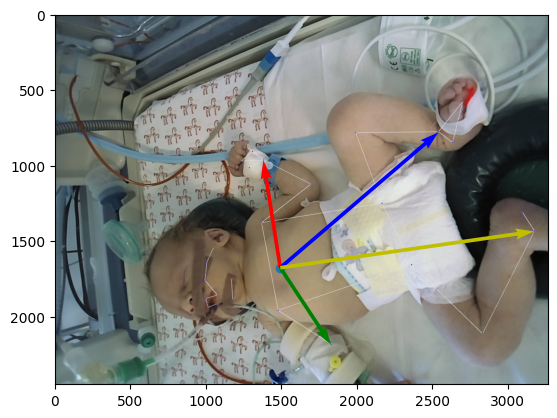

In [59]:
plt.scatter(predicted_core[0],predicted_core[1])
plt.quiver([predicted_core[0],predicted_core[0],predicted_core[0],predicted_core[0]],
           [predicted_core[1],predicted_core[1],predicted_core[1],predicted_core[1]],
           [vec_chest2hand1[0],vec_chest2hand2[0],vec_chest2leg1[0],vec_chest2leg2[0]],
           [vec_chest2hand1[1],vec_chest2hand2[1],vec_chest2leg1[1],vec_chest2leg2[1]], scale_units='xy', scale=1, color=['r', 'g', 'b', 'y'])
plt.xlim(0,img_mp.shape[1])
plt.ylim(img_mp.shape[0],0)
plt.imshow(img_mp)

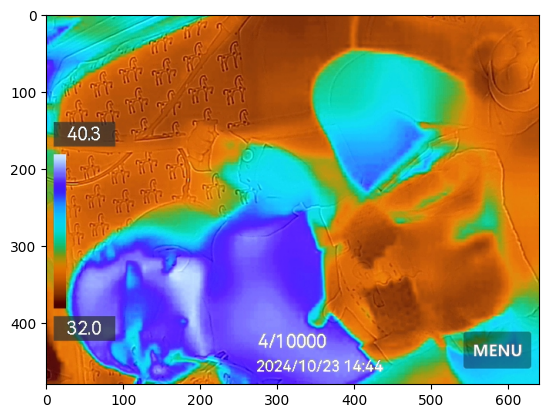

In [60]:
img_thermal = cv2.imread("images/40/23.10.24/HM20241023144414.jpeg")
plt.imshow(img_thermal)

(241, 375, 39.09045226130653)

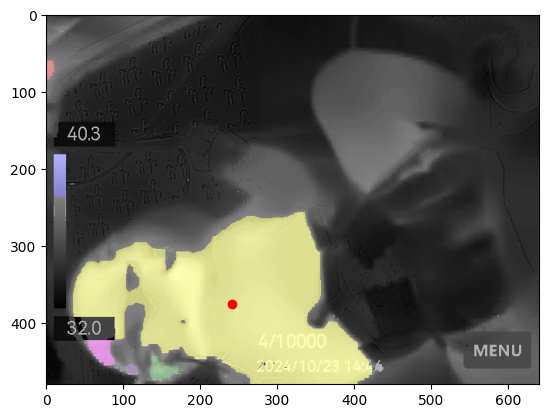

In [61]:
chest_finder(img_thermal,model)

### Encontrando la escala

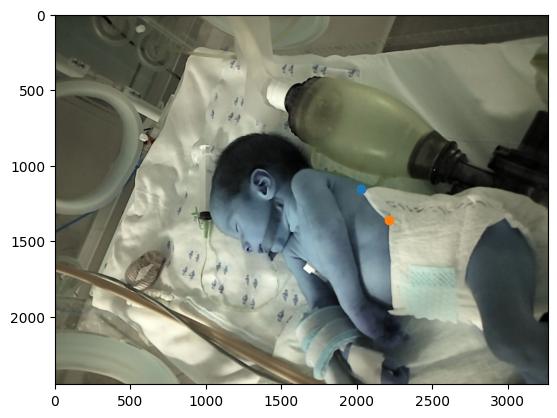

In [62]:
img_limb_detection = cv2.imread("images/47/01.12.24 (1)/HM20241201174656.VIS.jpeg")
img_thermal = cv2.imread("images/47/01.12.24 (1)/HM20241201174656.jpeg")
plt.scatter(2030,1155)
plt.scatter(2210,1360)
plt.imshow(img_limb_detection)

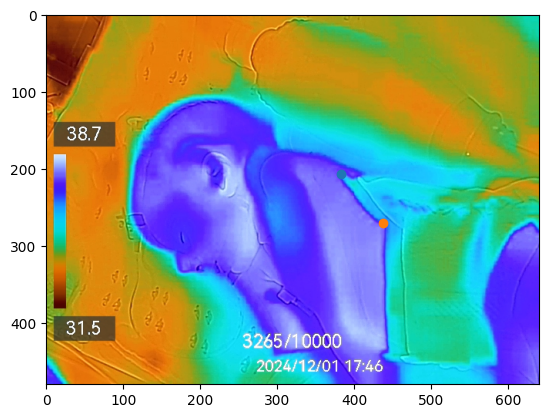

In [63]:
plt.scatter(383,207)
plt.scatter(437,270)
plt.imshow(img_thermal)

La escala entre el tamaño del pañal es 3.2891755. Por lo tanto, reduciréé los vectores en una escala de este valor para ajustarlos a la foto original.

In [64]:
img_thermal = cv2.imread("images/40/23.10.24/HM20241023144414.jpeg")
img_thermal = cv2.cvtColor(img_thermal, cv2.COLOR_BGR2RGB)


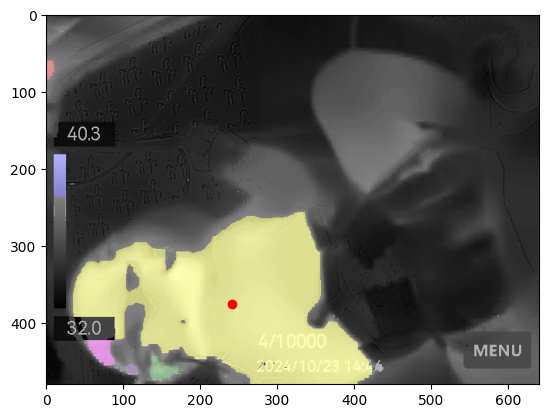

In [65]:
x,y,t = chest_finder(img_thermal,model)
scale = 3.2891755

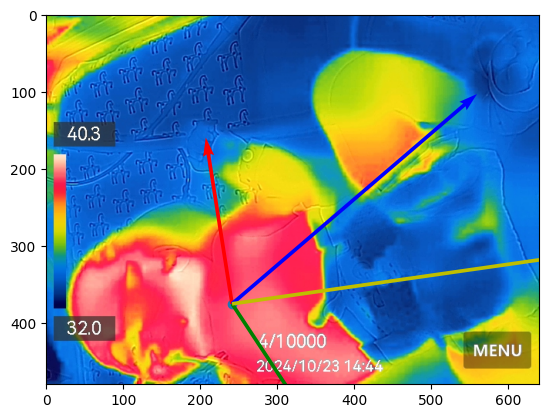

In [66]:
plt.scatter(x,y)
plt.quiver([x]*4,[y]*4,
           [vec_chest2hand1[0]/scale,vec_chest2hand2[0]/scale,vec_chest2leg1[0]/scale,vec_chest2leg2[0]/scale],
           [vec_chest2hand1[1]/scale,vec_chest2hand2[1]/scale,vec_chest2leg1[1]/scale,vec_chest2leg2[1]/scale],scale_units='xy', scale=1, color=['r', 'g', 'b', 'y'])
plt.imshow(img_thermal)


In [67]:
def find_original(img_path):
    img_base_path = img_path[:-5]
    if os.path.isfile(img_base_path+".VIS.jpeg"):
        return img_base_path+".VIS.jpeg"
    elif os.path.isfile(img_base_path+"_VIS.jpeg"):
        return img_base_path+".VIS.jpeg"
    return img_path

**PIPELINE**:
 - Tomar una foto en camara térmica
 - Extraer el mapa de calor
 - Emplear labelling para encontrar el pecho del bebé
 - Encontrar la imagen original
 - Extraer las extremidades empleando el modelo de mediapipe
 - Encontrar un vector que lleve desde el centro a las extremidades
 - Escalarlo y aplicarlo al pecho de la cámara térmica
 - Medir la diferencia de temperatura entre pecho y extremidades

In [68]:
def extract_keypoints(im_path):
    img_limb_detection = cv2.imread(im_path)

    img_mp = cv2.cvtColor(img_limb_detection, cv2.COLOR_BGR2RGB)

    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    mp_drawing = mp.solutions.drawing_utils

    results = pose.process(img_mp)

    if results.pose_landmarks:

        height,width,_ = img_mp.shape
        # Get landmark coordinates
        landmarks = results.pose_landmarks.landmark
        
        # Extract specific key points
        key_points = {
            "head": {
                "nose": np.array((landmarks[mp_pose.PoseLandmark.NOSE].x*width, landmarks[mp_pose.PoseLandmark.NOSE].y*height)),
                "left_eye": np.array((landmarks[mp_pose.PoseLandmark.LEFT_EYE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_EYE].y*height)),
                "right_eye": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_EYE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_EYE].y*height)),
                "left_ear": np.array((landmarks[mp_pose.PoseLandmark.LEFT_EAR].x*width, landmarks[mp_pose.PoseLandmark.LEFT_EAR].y*height)),
                "right_ear": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_EAR].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_EAR].y*height)),
            },
            "hands": {
                "left_wrist": np.array((landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x*width, landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y*height)),
                "right_wrist": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y*height)),
                "left_elbow": np.array((landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x*width, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y*height)),
                "right_elbow": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y*height))
            },
            "legs": {
                "left_knee": np.array((landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y*height)),
                "right_knee": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y*height)),
                "left_ankle": np.array((landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y*height)),
                "right_ankle": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y*height)),
            },
            "core" : {
                "left_shoulder": np.array((landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x*width, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y*height)),
                "right_shoulder": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y*height)),
                "left_hip": np.array((landmarks[mp_pose.PoseLandmark.LEFT_HIP].x*width,landmarks[mp_pose.PoseLandmark.LEFT_HIP].y*height)),
                "right_hip": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y*height))
            }    
        }
        return key_points


def get_thermal_keypoints(path):
    og_path = find_original(path)
    key_points = extract_keypoints(og_path)

    if key_points != None:
        predicted_core = (key_points["core"]["left_shoulder"]+
                    key_points["core"]["right_shoulder"]+
                    key_points["core"]["left_hip"]+
                    key_points["core"]["right_hip"]+
                    key_points["head"]["nose"]+
                    key_points["head"]["left_eye"]+
                    key_points["head"]["right_eye"])/7
        left_leg = decide_limb(key_points["legs"]["left_ankle"],key_points["legs"]["left_knee"],img_mp)
        right_leg = decide_limb(key_points["legs"]["right_ankle"],key_points["legs"]["right_knee"],img_mp)
        left_arm = decide_limb(key_points["hands"]["left_wrist"],key_points["hands"]["left_elbow"],img_mp)
        right_arm = decide_limb(key_points["hands"]["right_wrist"],key_points["hands"]["right_elbow"],img_mp)

        # Finding the vectors from the chest to the limbs
        vec_chest2hand1 = np.array([left_arm[0]-predicted_core[0],left_arm[1]-predicted_core[1]]) # Tengo que cambiar los ejes para el plot, a nivel de coordenadas será simplemente una resta
        vec_chest2hand2 = np.array([right_arm[0]-predicted_core[0],right_arm[1]-predicted_core[1]])
        vec_chest2leg1 = np.array([left_leg[0]-predicted_core[0],left_leg[1]-predicted_core[1]])
        vec_chest2leg2 = np.array([right_leg[0]-predicted_core[0],right_leg[1]-predicted_core[1]])

        # Scale vecs
        therm_ch2ha1 = vec_chest2hand1/3.2891755 # Escala de la imagen
        therm_ch2ha2 = vec_chest2hand2/3.2891755
        therm_ch2le1 = vec_chest2leg1/3.2891755
        therm_ch2le2 = vec_chest2leg2/3.2891755

        coord_x, coord_y , _ = chest_finder(cv2.imread(path),model,False)

        coord = np.array([coord_x,coord_y])

        ha1 = coord + therm_ch2ha1
        ha2 = coord + therm_ch2ha2
        le1 = coord + therm_ch2le1
        le2 = coord + therm_ch2le2

        return ha1, ha2, le1, le2



I0000 00:00:1741798248.336386  185699 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741798248.344488  187459 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: llvmpipe (LLVM 15.0.7, 256 bits)
W0000 00:00:1741798248.456074  187456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741798248.545823  187455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(array([447.01930236, -27.72183529]), array([394.53950465, 498.87518752]), array([7.64980786e+02, 5.42730897e-01]), array([762.92721216, 434.28692286]))


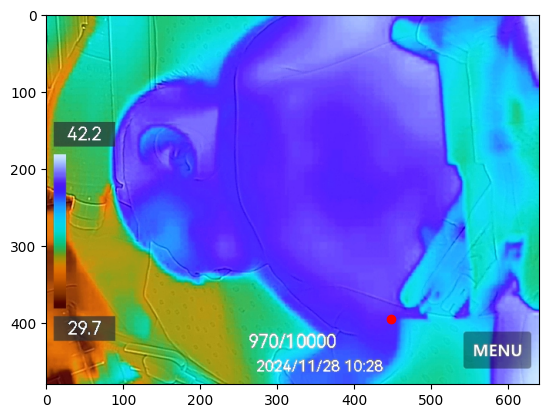

In [95]:
pos = 3
path = df["File_Path"][pos]
img = cv2.imread(path)
    
if not pd.isna(df["Chest"][pos]):
    vals = get_thermal_keypoints(path)
    if vals != None:
        print(vals)
        plt.scatter(vals[:][0],vals[:][1],color="red")
        plt.imshow(img)

In [106]:
key_points = extract_keypoints("images/49/28.11.24/HM20241128102807.VIS.jpeg")

I0000 00:00:1741798425.435800  185699 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741798425.443374  187510 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: llvmpipe (LLVM 15.0.7, 256 bits)
W0000 00:00:1741798425.554474  187505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741798425.631008  187502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


I0000 00:00:1741798426.089477  185699 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741798426.101223  187519 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: llvmpipe (LLVM 15.0.7, 256 bits)
W0000 00:00:1741798426.227997  187513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1741798426.357339  187518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


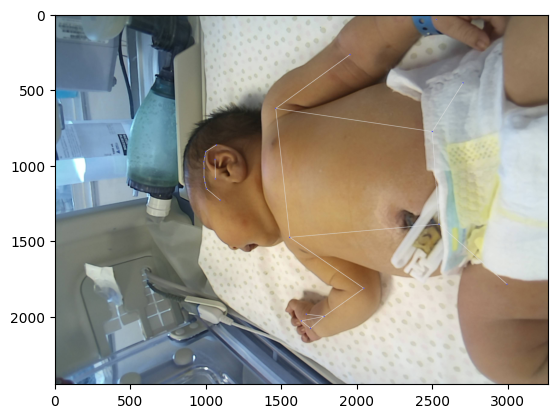

In [107]:
img_limb_detection = cv2.imread("images/49/28.11.24/HM20241128102807.VIS.jpeg")

img_mp = cv2.cvtColor(img_limb_detection, cv2.COLOR_BGR2RGB)

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

results = pose.process(img_mp)

if results.pose_landmarks:
    mp_drawing.draw_landmarks(img_mp, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

plt.imshow(img_mp)

In [111]:
if key_points != None:
    predicted_core = (key_points["core"]["left_shoulder"]+
                key_points["core"]["right_shoulder"]+
                key_points["core"]["left_hip"]+
                key_points["core"]["right_hip"]+
                key_points["head"]["nose"]+
                key_points["head"]["left_eye"]+
                key_points["head"]["right_eye"])/7
    left_leg = decide_limb(key_points["legs"]["left_ankle"],key_points["legs"]["left_knee"],img_mp)
    right_leg = decide_limb(key_points["legs"]["right_ankle"],key_points["legs"]["right_knee"],img_mp)
    left_arm = decide_limb(key_points["hands"]["left_wrist"],key_points["hands"]["left_elbow"],img_mp)
    right_arm = decide_limb(key_points["hands"]["right_wrist"],key_points["hands"]["right_elbow"],img_mp)
    # Finding the vectors from the chest to the limbs
    vec_chest2hand1 = np.array([left_arm[0]-predicted_core[0],left_arm[1]-predicted_core[1]]) # Tengo que cambiar los ejes para el plot, a nivel de coordenadas será simplemente una resta
    vec_chest2hand2 = np.array([right_arm[0]-predicted_core[0],right_arm[1]-predicted_core[1]])
    vec_chest2leg1 = np.array([left_leg[0]-predicted_core[0],left_leg[1]-predicted_core[1]])
    vec_chest2leg2 = np.array([right_leg[0]-predicted_core[0],right_leg[1]-predicted_core[1]])

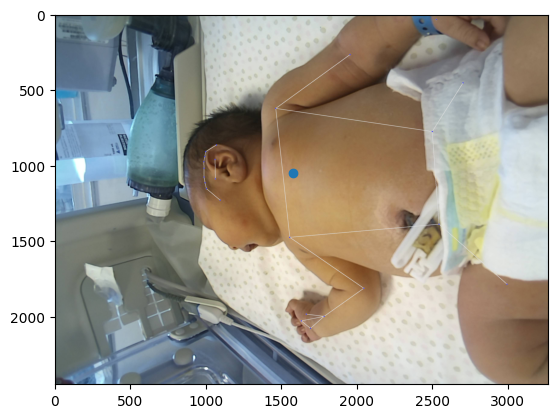

In [112]:
plt.scatter(predicted_core[0],predicted_core[1])
plt.imshow(img_mp)

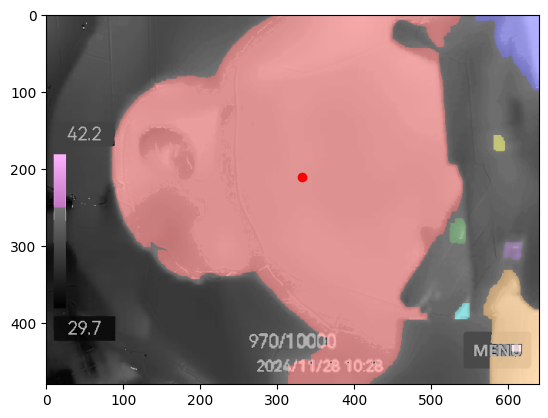

In [89]:
x,y, _ = chest_finder(cv2.imread("images/49/28.11.24/HM20241128102807.jpeg"),model)

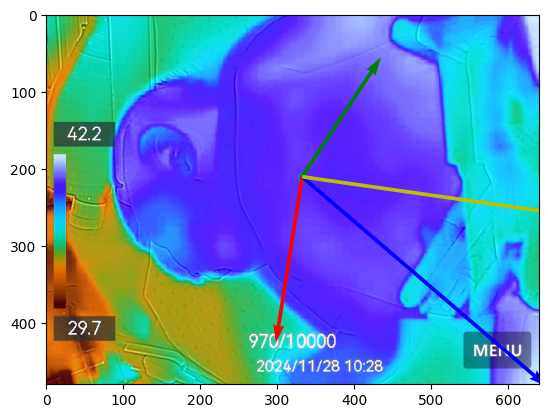

In [90]:
plt.scatter(x,y)
plt.quiver([x]*4,[y]*4,
           [vec_chest2hand1[0]/scale,vec_chest2hand2[0]/scale,vec_chest2leg1[0]/scale,vec_chest2leg2[0]/scale],
           [vec_chest2hand1[1]/scale,vec_chest2hand2[1]/scale,vec_chest2leg1[1]/scale,vec_chest2leg2[1]/scale],scale_units='xy', scale=1, color=['r', 'g', 'b', 'y'])
plt.imshow(cv2.imread("images/49/28.11.24/HM20241128102807.jpeg"))

### Cracking the crop

In [330]:
path = "images/40/23.10.24/HM20241023144414.jpeg"
#path = "images/41/01.11.24-02.11.24/HM20241101173406.jpeg"

# Path con fiebre "images/40/23.10.24/HM20241023144414.jpeg"
img_thermal = cv2.imread(path)
img_thermal = cv2.cvtColor(img_thermal,cv2.COLOR_BGR2RGB)
img_og = cv2.imread(path[:-5]+".VIS.jpeg")
img_og = cv2.cvtColor(img_og,cv2.COLOR_BGR2RGB)


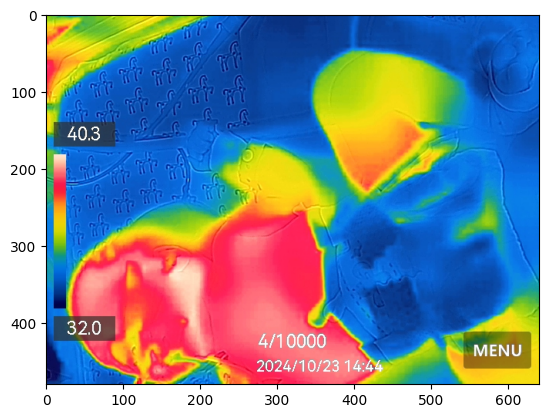

In [331]:
plt.imshow(img_thermal)

In [332]:
#Esto es una maravilla
cropped = cv2.resize(img_og[345:2055,500:2900,:],(640,480))

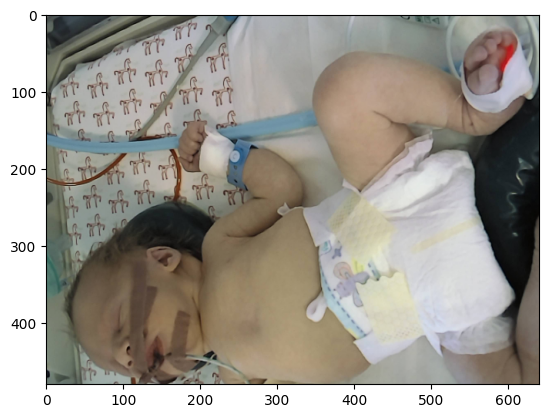

In [333]:
plt.imshow(cropped)

I0000 00:00:1742219263.249914  185699 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742219263.254439  245675 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: llvmpipe (LLVM 15.0.7, 256 bits)
W0000 00:00:1742219263.344624  245667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742219263.410735  245671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


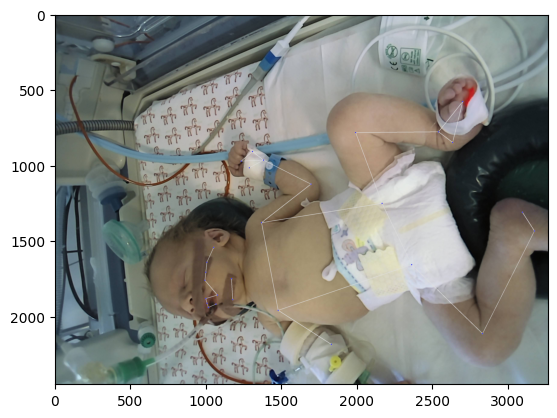

In [334]:
img_mp_og = img_og
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils
results = pose.process(img_mp_og)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(img_mp_og, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    height,width,_ = img_mp_og.shape
    # Get landmark coordinates
    landmarks = results.pose_landmarks.landmark
    
    # Extract specific key points
    key_points = {
        "head": {
            "nose": np.array((landmarks[mp_pose.PoseLandmark.NOSE].x*width, landmarks[mp_pose.PoseLandmark.NOSE].y*height)),
            "left_eye": np.array((landmarks[mp_pose.PoseLandmark.LEFT_EYE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_EYE].y*height)),
            "right_eye": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_EYE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_EYE].y*height)),
            "left_ear": np.array((landmarks[mp_pose.PoseLandmark.LEFT_EAR].x*width, landmarks[mp_pose.PoseLandmark.LEFT_EAR].y*height)),
            "right_ear": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_EAR].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_EAR].y*height)),
        },
        "hands": {
            "left_wrist": np.array((landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x*width, landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y*height)),
            "right_wrist": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y*height)),
            "left_elbow": np.array((landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x*width, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y*height)),
            "right_elbow": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y*height))
        },
        "legs": {
            "left_knee": np.array((landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y*height)),
            "right_knee": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y*height)),
            "left_ankle": np.array((landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y*height)),
            "right_ankle": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y*height)),
        },
        "core" : {
            "left_shoulder": np.array((landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x*width, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y*height)),
            "right_shoulder": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y*height)),
            "left_hip": np.array((landmarks[mp_pose.PoseLandmark.LEFT_HIP].x*width,landmarks[mp_pose.PoseLandmark.LEFT_HIP].y*height)),
            "right_hip": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y*height))
        }    
    }
plt.imshow(img_mp_og)

In [335]:
cropped_postpose = cv2.resize(img_mp_og[345:2055,500:2900,:],(640,480))


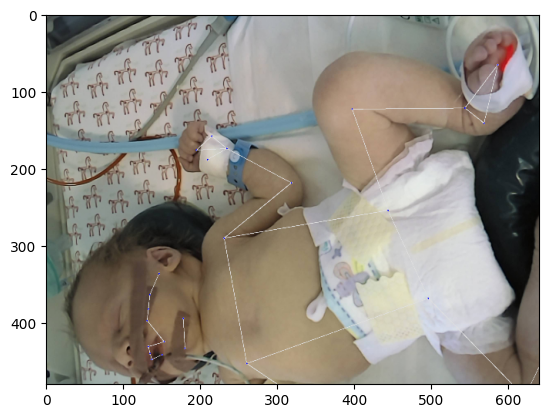

In [336]:
plt.imshow(cropped_postpose)

Aplicar el crop antes de que se encuentre la posa da los keypoints directamente, pero existen casos en los que no los encuentra correctamente. Es por eso que tomamos los keypoints originales y luego aplicamos el procedimiento en base al crop

In [337]:
derived_kpoints = key_points
for sec_name, section in key_points.items():
    for name,coord in section.items():
        new_x = (coord[0]-500)*0.2667
        new_y = (coord[1]-245)*0.2657
        derived_kpoints[sec_name][name] = np.array([new_x,new_y])
derived_kpoints

{'head': {'nose': array([153.45215743, 428.90457998]),
  'left_eye': array([132.89083515, 388.91302388]),
  'right_eye': array([135.01786491, 443.22618592]),
  'left_ear': array([146.93388059, 345.18077643]),
  'right_ear': array([150.78395286, 444.89076585])},
 'hands': {'left_wrist': array([234.94509424, 191.6024977 ]),
  'right_wrist': array([417.12160797, 608.46055613]),
  'left_elbow': array([318.60112184, 233.94172172]),
  'right_elbow': array([354.59147823, 515.63184617])},
 'legs': {'left_knee': array([397.53481544, 143.23337785]),
  'right_knee': array([621.55145843, 496.60835245]),
  'left_ankle': array([543.96447551, 142.12642987]),
  'right_ankle': array([713.27042004, 316.36667142])},
 'core': {'left_shoulder': array([231.40737791, 301.62752483]),
  'right_shoulder': array([260.75147973, 455.71642826]),
  'left_hip': array([444.14983959, 267.74660071]),
  'right_hip': array([496.42670419, 375.6250734 ])}}

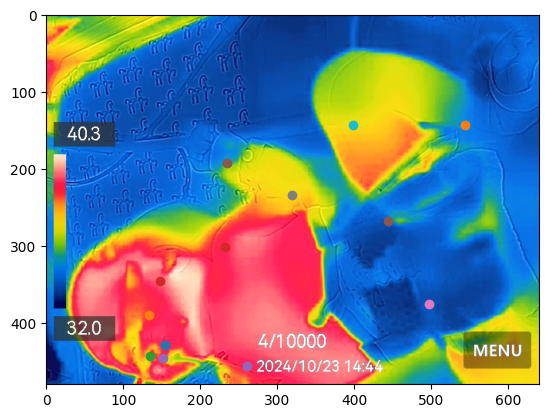

In [338]:
for sec_name, section in derived_kpoints.items():
    for name,coord in section.items():
        plt.scatter(coord[0],coord[1])
plt.imshow(img_thermal)

In [339]:
gimg, temps = temp_classifier_gpu(img_thermal,model)
for section in derived_kpoints.values():
    for name,coord in section.items():
        if check_borders(coord,(0,0),(480,640)):
            print("Temperatura",name,":",temps[int(coord[1])][int(coord[0])])
        else:
            print("Temperatura",name,": Se sale de la imagen")

Temperatura nose : 38.79849246231156
Temperatura left_eye : 38.17286432160804
Temperatura right_eye : 37.92261306532663
Temperatura left_ear : 39.34070351758794
Temperatura right_ear : 38.29798994974874
Temperatura left_wrist : 34.79447236180904
Temperatura right_wrist : Se sale de la imagen
Temperatura left_elbow : 36.754773869346735
Temperatura right_elbow : Se sale de la imagen
Temperatura left_knee : 36.58793969849246
Temperatura right_knee : Se sale de la imagen
Temperatura left_ankle : 34.25226130653266
Temperatura right_ankle : Se sale de la imagen
Temperatura left_shoulder : 38.79849246231156
Temperatura right_shoulder : 38.84020100502512
Temperatura left_hip : 33.87688442211055
Temperatura right_hip : 33.37638190954774


Como se puede observar, los valores de la cadera se ven afectados por el pañal, por lo que se plantea coger un punto medio del torso entre los hombros y la cadera    

In [327]:
def get_keypoints(img_limb_detection):
    img_mp = cv2.cvtColor(img_limb_detection, cv2.COLOR_BGR2RGB)

    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    mp_drawing = mp.solutions.drawing_utils

    results = pose.process(img_mp)

    if results.pose_landmarks:

        height,width,_ = img_mp.shape
        # Get landmark coordinates
        landmarks = results.pose_landmarks.landmark
        
        # Extract specific key points
        key_points = {
            "head": {
                "nose": np.array((landmarks[mp_pose.PoseLandmark.NOSE].x*width, landmarks[mp_pose.PoseLandmark.NOSE].y*height)),
                "left_eye": np.array((landmarks[mp_pose.PoseLandmark.LEFT_EYE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_EYE].y*height)),
                "right_eye": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_EYE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_EYE].y*height)),
                "left_ear": np.array((landmarks[mp_pose.PoseLandmark.LEFT_EAR].x*width, landmarks[mp_pose.PoseLandmark.LEFT_EAR].y*height)),
                "right_ear": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_EAR].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_EAR].y*height)),
            },
            "hands": {
                "left_wrist": np.array((landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x*width, landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y*height)),
                "right_wrist": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y*height)),
                "left_elbow": np.array((landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x*width, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y*height)),
                "right_elbow": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y*height))
            },
            "legs": {
                "left_knee": np.array((landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y*height)),
                "right_knee": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y*height)),
                "left_ankle": np.array((landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x*width, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y*height)),
                "right_ankle": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x*width, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y*height)),
            },
            "core" : {
                "left_shoulder": np.array((landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x*width, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y*height)),
                "right_shoulder": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y*height)),
                "left_hip": np.array((landmarks[mp_pose.PoseLandmark.LEFT_HIP].x*width,landmarks[mp_pose.PoseLandmark.LEFT_HIP].y*height)),
                "right_hip": np.array((landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x*width,landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y*height))
            }    
        }
        key_points["core"]["chest"] = (key_points["core"]["left_hip"]+key_points["core"]["right_hip"] + key_points["core"]["left_shoulder"] + key_points["core"]["right_shoulder"])/4
        return key_points

In [328]:
def get_keypoint_temperature (img_thermal, img_og):
    keypoints = get_keypoints(img_og)
    derived_kpoints = keypoints
    if derived_kpoints != None:
        for sec_name, section in keypoints.items():
            for name,coord in section.items(): # Resultados de aplicar el crop [345:2055,500:2900,:] y el escalado (640,480)
                new_x = (coord[0]-500)*0.2667
                new_y = (coord[1]-245)*0.2657
                derived_kpoints[sec_name][name] = np.array([new_x,new_y])
    else:
        print("No hay bebé")
        return None
    #cropped = cv2.resize(img_og[345:2055,500:2900,:],(640,480))

    _, temps = temp_classifier_gpu(img_thermal,model)
    temp_vals = {}
    for section in derived_kpoints.values():
        for name,coord in section.items():
            if check_borders(coord,(0,0),(480,640)):
                print("Temperatura",name,":",temps[int(coord[1])][int(coord[0])])
                temp_vals[name] = round(temps[int(coord[1])][int(coord[0])],3)
            else:
                print("Temperatura",name,": Se sale de la imagen")
                temp_vals[name] = None
    return temp_vals

In [340]:
path = "images/40/23.10.24/HM20241023144414.jpeg"
img_thermal = cv2.imread(path)
img_complete = cv2.imread(path[:-5]+".VIS.jpeg")

T = get_keypoint_temperature(img_thermal,img_complete)


I0000 00:00:1742220370.424948  185699 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742220370.433191  245857 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: llvmpipe (LLVM 15.0.7, 256 bits)
W0000 00:00:1742220370.525861  245854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742220370.598174  245850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Temperatura nose : 38.79849246231156
Temperatura left_eye : 38.17286432160804
Temperatura right_eye : 37.92261306532663
Temperatura left_ear : 39.34070351758794
Temperatura right_ear : 38.29798994974874
Temperatura left_wrist : 34.79447236180904
Temperatura right_wrist : Se sale de la imagen
Temperatura left_elbow : 36.754773869346735
Temperatura right_elbow : Se sale de la imagen
Temperatura left_knee : 36.58793969849246
Temperatura right_knee : Se sale de la imagen
Temperatura left_ankle : 34.25226130653266
Temperatura right_ankle : Se sale de la imagen
Temperatura left_shoulder : 38.79849246231156
Temperatura right_shoulder : 38.84020100502512
Temperatura left_hip : 33.87688442211055
Temperatura right_hip : 33.37638190954774
Temperatura chest : 37.75577889447236


In [341]:
path = "images/41/01.11.24-02.11.24/HM20241101173406.jpeg"

img_thermal = cv2.imread(path)
img_complete = cv2.imread(path[:-5]+".VIS.jpeg")

T = get_keypoint_temperature(img_thermal,img_complete)

No hay bebé


I0000 00:00:1742220383.819833  185699 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742220383.829603  245869 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: llvmpipe (LLVM 15.0.7, 256 bits)
W0000 00:00:1742220383.955636  245861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742220384.015909  245862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Los bebés que se encuentran de espaldas o las fotos sacadas con un mal ángulo resultan en "None"